<h3>Import Libraries</h3>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import warnings
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<h3>Reading Feature File as a DataFrame</h3>

In [2]:
features = pd.read_csv('/kaggle/input/features-for-mental-stress-classification/features_mental_stress.csv')
features.shape

(5544, 211)

<h3>Cleaning Data and Removing Outliers</h3> 

In [3]:
#normalize data using standard scaler
def get_clean_data(df_ss,threshold):
    from sklearn.preprocessing import StandardScaler
    SS = StandardScaler()
    temp_df = df_ss.copy()
    for col in df_ss.columns:
        if col=='label': continue
        temp_df[[col]] = SS.fit_transform(temp_df[[col]])
        df_ss=df_ss[(temp_df[col]<threshold) & (temp_df[col]>-threshold)].astype(float)
#     clear_output(wait=False)
    return df_ss

In [4]:
#creating two datasets to seperate stressed and unstressed data 
threshold = 4.7
df_uns = get_clean_data(features[features['label'] == 0],threshold)  #unstressed data
df_str = get_clean_data(features[features['label'] == 1],threshold) #stressed data
final_features = pd.concat([df_uns,df_str], axis=0, ignore_index=True).astype(float)
print(df_uns.shape)
print(df_str.shape)
print(final_features.shape)

(2453, 211)
(2463, 211)
(4916, 211)


<h3>Around 10% outliers were removed</h3>

In [5]:
(features.shape[0]-final_features.shape[0])/features.shape[0]

0.11327561327561328

In [6]:
final_features.sample(10)

,Fp1_del,Fp1_the,Fp1_alp,Fp1_sig,Fp1_bet,Fp1_gam,Fp1_per,Fp1_sam,Fp1_hig,Fp1_pet,...,ECG_the,ECG_alp,ECG_sig,ECG_bet,ECG_gam,ECG_per,ECG_sam,ECG_hig,ECG_pet,label
913,0.384331,0.147707,0.147828,0.080792,0.163344,0.085990,0.647156,0.450927,1.244211,1.007225,...,0.224030,0.122344,0.126176,0.221235,0.015020,0.663058,0.194627,1.195067,1.007783,0.0
3076,0.121251,0.302816,0.196851,0.152017,0.207044,0.030346,0.633508,0.343585,1.163102,1.006665,...,0.198863,0.181409,0.162855,0.254889,0.021850,0.599329,0.059283,1.104287,1.005767,1.0
3913,0.180477,0.296991,0.227698,0.075067,0.213731,0.025976,0.605008,0.393107,1.153599,1.005654,...,0.240334,0.195608,0.120621,0.239577,0.019750,0.593574,0.144569,1.098567,1.005372,1.0
2455,0.155915,0.133147,0.378684,0.161861,0.142417,0.019650,0.577692,0.422763,1.117503,1.004751,...,0.271761,0.249067,0.124948,0.124246,0.005242,0.561849,0.105700,1.078865,1.004468,1.0
341,0.367184,0.210596,0.200033,0.085296,0.134172,0.019596,0.608031,0.249893,1.133917,1.005767,...,0.221269,0.146226,0.119696,0.281091,0.016567,0.571349,0.117059,1.099520,1.004864,0.0
1211,0.218439,0.389437,0.297037,0.063575,0.075330,0.008324,0.587107,0.286841,1.081246,1.005033,...,0.358006,0.223881,0.095391,0.118402,0.005597,0.636730,0.095445,1.091578,1.006833,0.0
1968,0.107084,0.167222,0.477342,0.118941,0.138451,0.038954,0.578313,0.378047,1.104090,1.004751,...,0.237954,0.143857,0.100124,0.245221,0.048252,0.606002,0.105426,1.139617,1.005992,0.0
3419,0.470378,0.155017,0.041017,0.092401,0.213322,0.025703,0.655156,0.432013,1.233036,1.007560,...,0.201100,0.130813,0.130613,0.238278,0.014067,0.657109,0.232516,1.179492,1.007560,1.0
4754,0.348480,0.283933,0.118808,0.066204,0.127797,0.024254,0.608556,0.353040,1.153671,1.005823,...,0.138385,0.200184,0.181398,0.224487,0.024201,0.633311,0.264149,1.171372,1.006721,1.0
2133,0.226589,0.266202,0.229179,0.106120,0.150703,0.037617,0.625951,0.425727,1.190918,1.006385,...,0.298170,0.165409,0.095330,0.110681,0.002105,0.571720,0.043322,1.058460,1.004864,0.0


<h1>Classification using Ensemble Technique</h1>

<h3>Splitting Dataset into Train(85%) and Test(15%)</h3>

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler
over = RandomOverSampler(random_state=100)

X= final_features.drop('label',axis=1)
y = final_features['label']
print(y.value_counts())
X,y = over.fit_resample(X,y)
print(X.shape)
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


label
1.0    2463
0.0    2453
Name: count, dtype: int64
(4926, 210)
label
0.0    2463
1.0    2463
Name: count, dtype: int64


<h3>Function for Performing Classification</h3>

In [17]:
def perfrom_prediction(model):
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    return accuracy,pred

def perform_dt():
    from sklearn.tree import DecisionTreeClassifier
    dt = DecisionTreeClassifier(random_state=42) 
    return perfrom_prediction(dt.fit(X_train, y_train))

def perform_knn():
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors=7)
    return perfrom_prediction(knn.fit(X_train, y_train))

def perform_svc():
    from sklearn.svm import SVC
    svc = SVC(kernel='linear',random_state=42) 
    return perfrom_prediction(svc.fit(X_train, y_train))

def perform_lr():
    from sklearn.linear_model import LogisticRegression
    lr = LogisticRegression(max_iter=1000)
    return perfrom_prediction(lr.fit(X_train, y_train))

def perform_xgb():
    from xgboost import XGBClassifier
    xgb = XGBClassifier()
    return perfrom_prediction(xgb.fit(X_train, y_train))

def perform_rf():
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(random_state=42)
    return perfrom_prediction(rf.fit(X_train, y_train))

def perform_ann(epochs,lr):
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.optimizers import Adam
    
    model = keras.Sequential([
        layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(1024*2, activation='relu'),
        layers.Dense(1024*2, activation='relu'),
        layers.Dense(1024, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_split=0.1)
    y_pred = model.predict(X_test)
    pred_ann = []
    for i in y_pred:
        if i>0.5: pred_ann.append(1)
        else: pred_ann.append(0)
    accuracy = accuracy_score(y_test, pred_ann)
    return accuracy,pred_ann

<h3>Perfrom Classification</h3>

In [29]:
acc_dt,pred_dt = perform_dt()
acc_knn,pred_knn = perform_knn()
acc_svc,pred_svc = perform_svc()
acc_lr,pred_lr = perform_lr()
acc_xgb,pred_xgb = perform_xgb()
acc_rf,pred_rf = perform_rf()
acc_ann,pred_ann = perform_ann(30,0.001)
clear_output(wait=False)
print(f'Decision Tree ============> {round(acc_dt,4)}')
print(f'Support Vector Classifier > {round(acc_svc,4)}')
print(f'Logistic Regression ======> {round(acc_lr,4)}')
print(f'Knn ======================> {round(acc_knn,4)}')
print(f'XG boost =================> {round(acc_xgb,4)}')
print(f'Random Forest=============> {round(acc_rf,4)}')
print(f'ANN ======================> {round(acc_ann,4)}')

Decision Tree ============> 0.8674
Support Vector Classifier > 0.8525
Logistic Regression ======> 0.8376
Knn ======================> 0.9689
XG boost =================> 0.9838
Random Forest=============> 0.9608
ANN ======================> 0.9905


<h2>Ensemble Technique: Top 3 models were selected(KNN, XGBoost, ANN)</h2>
<h3>Using Majority Voting</h3>

In [89]:
pred_ens = []
for preds in zip(pred_knn,pred_xgb,pred_ann):
    sum = 0
    for p in preds:
        sum = sum+p
    if sum > 1: pred_ens.append(1)
    else: pred_ens.append(0)
        
acc_ens = accuracy_score(y_test, pred_ens)
print(f"Ensemble Model Accuracy: {acc_ens}")

Ensemble Model Accuracy: 0.9945872801082544


<h3>Using Weighted Ensemble Technique</h3>

In [90]:
acc_all = [acc_knn,acc_xgb,acc_ann]
sum_acc = 0
for acc in acc_all:
    sum_acc = sum_acc+acc
weights = []
for acc in acc_all:
    weights.append(acc/sum_acc)
print(f'weights: {weights}')

weights: [0.32919540229885064, 0.3342528735632184, 0.33655172413793105]


In [91]:
pred_ens = []
for preds in zip(pred_knn,pred_xgb,pred_ann):
    sum = 0
    for i in range(0,3):
        sum = sum + preds[i]*weights[i]
    if sum > 0.5: pred_ens.append(1)
    else: pred_ens.append(0)
acc_ens = accuracy_score(y_test, pred_ens)
print(f"Weighted Ensemble Model Accuracy: {acc_ens}")

Weighted Ensemble Model Accuracy: 0.9945872801082544


<h2>Result Analysis</h2>

In [99]:
from sklearn.metrics import confusion_matrix,classification_report,precision_recall_fscore_support
def showClassificationReport(y_pred):    
    cr = classification_report(y_test, y_pred,digits=4)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    return cr,[precision, recall, f1_score]
def plotCM(y_pred,model_name):
    label_info = ['Relaxed','Stressed']
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize = (10, 5))
    sns.heatmap(cm, annot = True, 
               fmt = "d", linewidths = 0.4,
               square = True,
               cmap = "Blues",
               xticklabels = label_info, 
               yticklabels = label_info)
    plt.xlabel("Actual Labels")
    plt.ylabel("Predcited labels")
    plt.title(f"Mental Stress Classification using {model_name}")
    plt.savefig(f'/kaggle/working/cm_{model_name}.png')
    plt.show()

result_params = ['Precision','Recall','F1_Score','Accuracy']

<h3>KNN</h3>

96.91% : Precision
96.89% : Recall
96.89% : F1_Score
96.89% : Accuracy
------------------


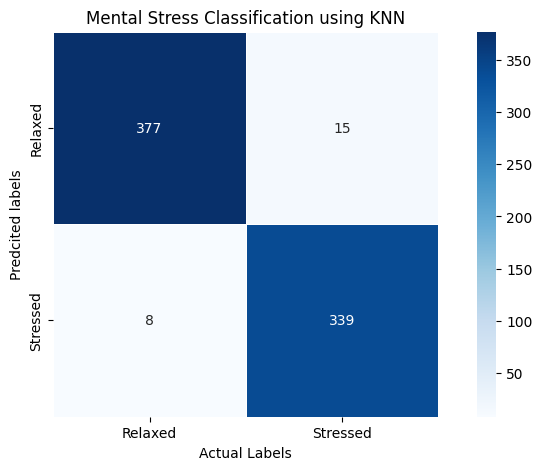

In [102]:
cr_knn,result_knn = showClassificationReport(pred_knn)
result_knn.append(acc_knn)
result_knn = [round(r*100,2) for r in result_knn]
for r in zip(result_params,result_knn):
    print(f'{r[1]}% : {r[0]}')
print('------------------')
plotCM(pred_knn,"KNN")

<h3>XGBoost</h3>

98.41% : Precision
98.38% : Recall
98.38% : F1_Score
98.38% : Accuracy
------------------


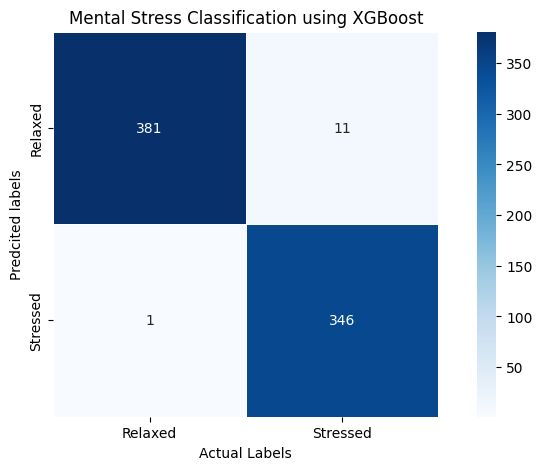

In [103]:
cr_xgb,result_xgb = showClassificationReport(pred_xgb)
result_xgb.append(acc_xgb)
result_xgb = [round(r*100,2) for r in result_xgb]
for r in zip(result_params,result_xgb):
    print(f'{r[1]}% : {r[0]}')
print('------------------')
plotCM(pred_xgb,"XGBoost")

<h3>ANN</h3>

99.07% : Precision
99.05% : Recall
99.05% : F1_Score
99.05% : Accuracy
------------------


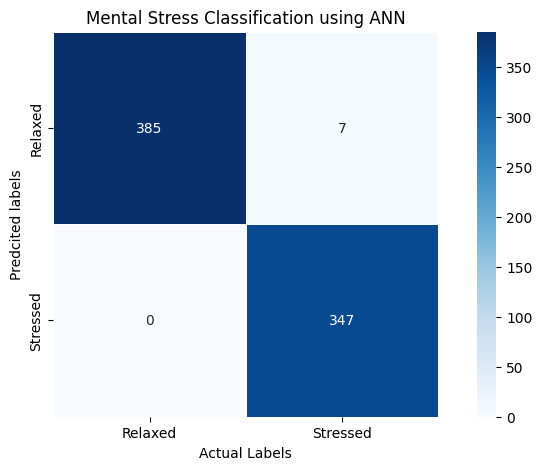

In [104]:
cr_ann,result_ann = showClassificationReport(pred_ann)
result_ann.append(acc_ann)
result_ann = [round(r*100,2) for r in result_ann]
for r in zip(result_params,result_ann):
    print(f'{r[1]}% : {r[0]}')
print('------------------')
plotCM(pred_ann,"ANN")

<h3>Ensemble Technique</h3>

99.46% : Precision
99.46% : Recall
99.46% : F1_Score
99.46% : Accuracy
------------------


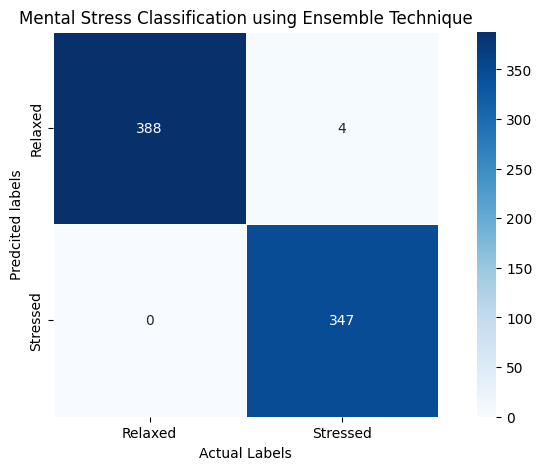

In [105]:
cr_ens,result_ens = showClassificationReport(pred_ens)
result_ens.append(acc_ens)
result_ens = [round(r*100,2) for r in result_ens]
for r in zip(result_params,result_ens):
    print(f'{r[1]}% : {r[0]}')
print('------------------')
plotCM(pred_ens,"Ensemble Technique")

<h3>Result Comparison</h3>

In [120]:
result_all = [result_knn,result_xgb,result_ann,result_ens]
result_df = pd.DataFrame(result_all,columns = result_params)
result_df['Model'] = ['KNN','XGB','ANN','ENS']
result_df

,Precision,Recall,F1_Score,Accuracy,Model
0,96.91,96.89,96.89,96.89,KNN
1,98.41,98.38,98.38,98.38,XGB
2,99.07,99.05,99.05,99.05,ANN
3,99.46,99.46,99.46,99.46,ENS


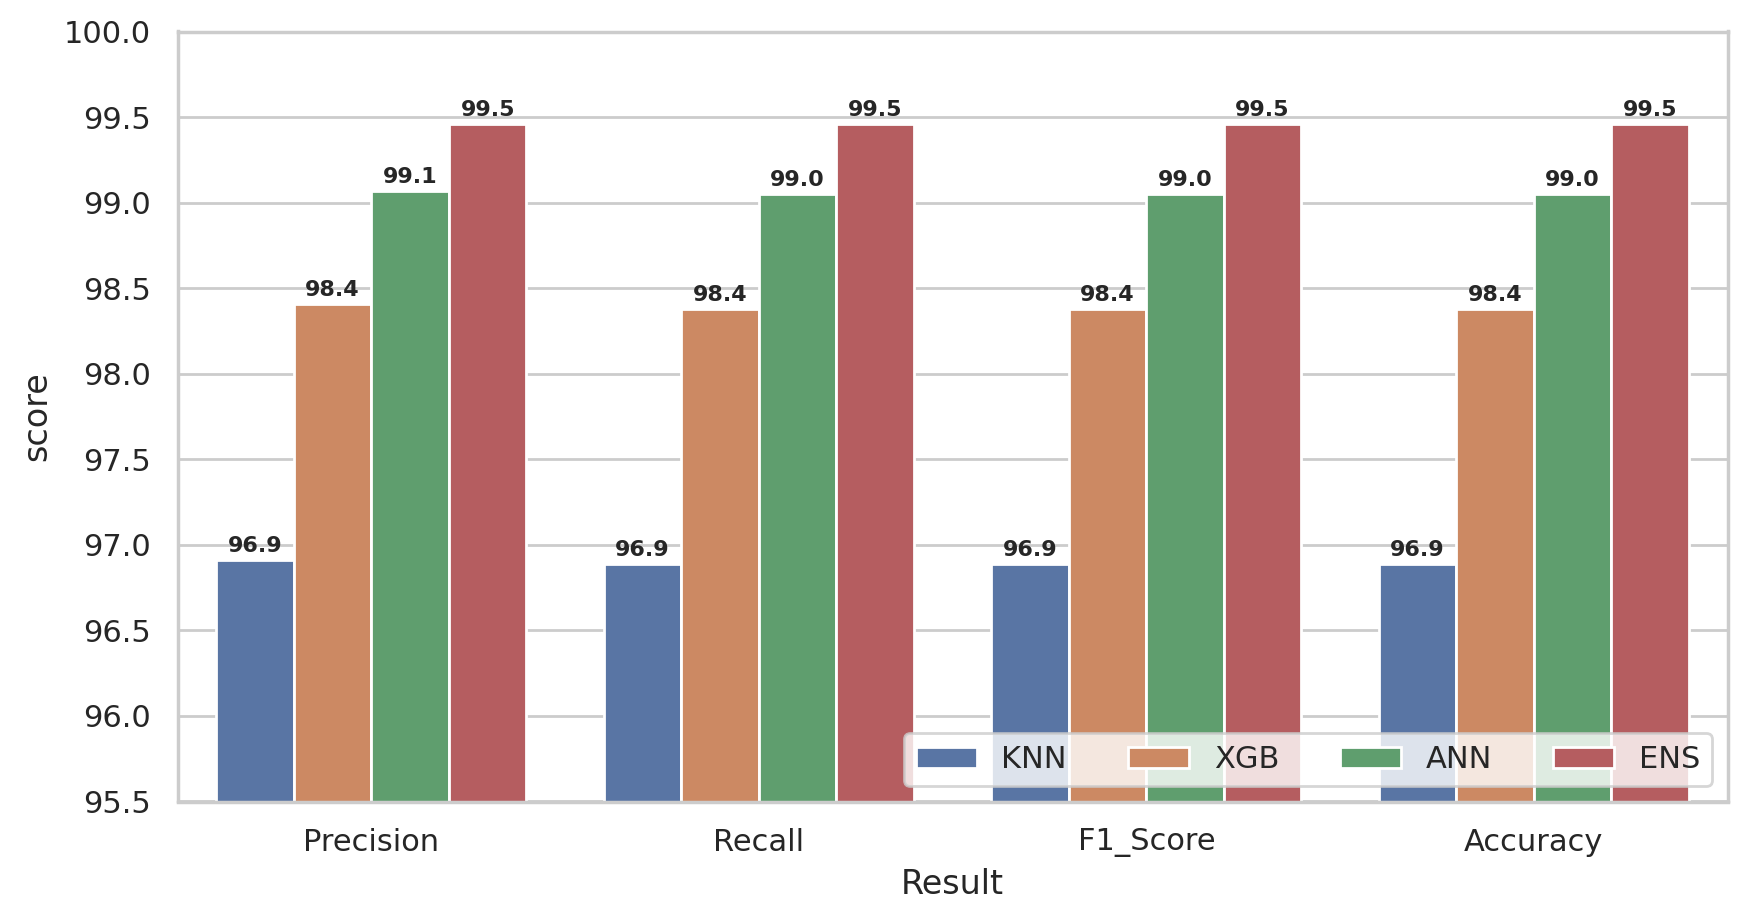

In [194]:
models = ['KNN','XGB','ANN','ENS']
plot_df = []
for i,params in enumerate(result_params):
    for j,model in enumerate(models):
        plot_df.append([params,model,result_all[j][i]])
plot_df = pd.DataFrame(plot_df,columns = ['Result','model','score'])

plt.figure(figsize = (10, 5),dpi=200)
ax=sns.barplot(x="Result", 
           y="score", 
           hue="model", 
           data=plot_df) 
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points',fontsize=8,weight='bold')
    
plt.ylim(95.5,100)
ax.legend(loc='lower right',ncol=4)
plt.savefig(f'/kaggle/working/bar_plot.png')
plt.show()